In [1]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [2]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.32.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
TensorFlow version: 2.4.1


In [23]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


In [24]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten_16 (Flatten)         (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 35s 2ms/step - loss: 0.7728 - accuracy: 0.7440
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4373 - accuracy: 0.8478
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3954 - accuracy: 0.8608
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 

In [25]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 88
drwxr-xr-x 2 root root  4096 Mar  4 00:51 assets
-rw-r--r-- 1 root root 79522 Mar  4 00:51 saved_model.pb
drwxr-xr-x 2 root root  4096 Mar  4 00:51 variables


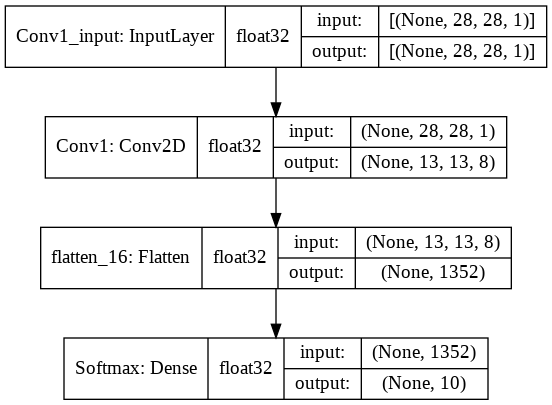

In [26]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [27]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0304 00:51:49.219069 140212585498496 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pytho

In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [ ]:
import json

with open('request.json', 'w') as f:
    json.dump({"signature_name": "serving_default", "instances": test_images[0:3].tolist()}, f)

#data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
#print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

In [ ]:
#!pip install -q requests

#import requests
#headers = {"content-type": "application/json"}
#json_response = requests.post('http://localhost:8501/v1/models/Fashion:predict', data=data, headers=headers)
#predictions = json.loads(json_response.text)['predictions']

#show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
#  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

In [ ]:
#### Same as above but specifies API version number

#headers = {"content-type": "application/json"}
#json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
#predictions = json.loads(json_response.text)['predictions']

#for i in range(0,3):
#  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
#    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))

In [ ]:
myArray = (28,28,1)

In [ ]:
myArray

In [30]:
import numpy as np
from skimage import transform, io
import matplotlib.pyplot as plt


img_array = io.imread("https://shop.tate.org.uk/dw/image/v2/BBPB_PRD/on/demandware.static/-/Sites-TateMasterShop/default/dwaa107262/tate-logo-black--tshirt-back-g1086.jpg", as_gray=True)
small_grey = transform.resize(
  img_array, (28, 28,1), mode='symmetric', preserve_range=True)
img_to_predict = np.expand_dims(small_grey / 255.0, 0)

img_to_pre = np.expand_dims(small_grey / 255.0, 0)

In [31]:
model.predict(img_to_pre)

array([[1.2312507e-03, 5.0433682e-05, 8.8086417e-05, 1.4949542e-05,
        3.3409403e-06, 9.8830098e-01, 3.5509243e-04, 3.6847556e-04,
        9.5809884e-03, 6.4588239e-06]], dtype=float32)

In [ ]:
plt.imshow(img_to_pre.reshape(28,28))